# Kaplan–Meier plots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from lifelines import KaplanMeierFitter
from matplotlib.pyplot import figure
from lifelines.statistics import logrank_test

In [2]:
#good
def Surv(counts):
    T = []; E = []; T1 = []; T0 = []; E1 = []; E0 = []
    counts = np.trim_zeros(counts, trim='f')
    deaths = counts[:-1]-counts[1:]
    start = counts[0]
    T1 = [[i+1]*deaths[i] for i in range(len(deaths)) if deaths[i]>0]
    T1 = [item for sublist in T1 for item in sublist]
    E1 = [1]*len(T1)
    T0 = [(len(counts)-1) for i in range(start-deaths.sum())]
    E0 = [0]*len(T0)
    T1.extend(T0); T = T1
    E1.extend(E0); E = E1
    return ({'T':T, 'E':E})
def Survs(countss):
    T = []; E = []    
    for counts in countss:
        surv = Surv(counts)
        T = np.concatenate((T, surv['T']))
        E = np.concatenate((E, surv['E']))
    return ({'T':T.astype(np.int8).tolist(), 'E':E.astype(np.int8).tolist()})

# Load lifespan

In [4]:
lifespan = pd.read_csv('fruitfly_lifespan.tsv', delimiter='\t'); print(lifespan.shape); lifespan = lifespan[lifespan['dont_use']==0]; print(lifespan.shape)
#lifespan['condition_replicate'] = lifespan['condition'] + '-' +  lifespan['replicate']
print(lifespan.columns)
lifespan = lifespan[['camera', 'position', 'vial', 'condition', 'concentration', 'compound', 'repetition', 'replicate', 'date_of_birth', 'start_flies', 'dont_use',
                     '08/07/2021', '16/07/2021', '22/07/2021', '29/07/2021', '05/08/2021', '12/08/2021', '19/08/2021', '26/08/2021', '02/09/2021', '09/09/2021', '16/09/2021', 
                     '23/09/2021', '30/09/2021', '07/10/2021', '14/10/2021', '21/10/2021', '28/10/2021', '04/11/2021', '11/11/2021', '18/11/2021', '25/11/2021', '02/12/2021',
                     '09/12/2021', '16/12/2021','23/12/2021', '30/12/2021']]
#lifespan = lifespan[lifespan['repetition']==1]
#lifespan = lifespan[lifespan['condition'].isin(['DMSO-1', 'B-1', 'SD'])]
lifespan = lifespan.reset_index(drop=True)
lifespan

(117, 38)
(117, 38)
Index(['Unnamed: 0', 'camera', 'position', 'vial', 'condition',
       'concentration', 'compound', 'repetition', 'replicate', 'date_of_birth',
       'start_flies', 'dont_use', '08/07/2021', '16/07/2021', '22/07/2021',
       '29/07/2021', '05/08/2021', '12/08/2021', '19/08/2021', '26/08/2021',
       '02/09/2021', '09/09/2021', '16/09/2021', '23/09/2021', '30/09/2021',
       '07/10/2021', '14/10/2021', '21/10/2021', '28/10/2021', '04/11/2021',
       '11/11/2021', '18/11/2021', '25/11/2021', '02/12/2021', '09/12/2021',
       '16/12/2021', '23/12/2021', '30/12/2021'],
      dtype='object')


camera position  vial condition concentration compound  repetition  \
0         1        A     1        SD           NaN       SD           1   
1         1        B     2   DMSO-01        0.001%     DMSO           1   
2         1        C     3    DMSO-1         0.01%     DMSO           1   
3         1        D     4   DMSO-10          0.1%     DMSO           1   
4         2        A     5  DMSO-100            1%     DMSO           1   
..      ...      ...   ...       ...           ...      ...         ...   
112       9        C   113     A-100        100 µM        A           3   
113       9        D   114      B-01        0.1 µM        B           3   
114      10        A   115       B-1          1 µM        B           3   
115      10        B   116      B-10         10 µM        B           3   
116      10        C   117     B-100        100 µM        B           3   

    replicate date_of_birth  start_flies  ...  28/10/2021  04/11/2021  \
0           A    08/07/2021           10  ...           0           0   
1           A    08/07/2021           10  ...           0           0   
2           A    08/07/2021           10  ...           0           0   
3           A    08/07/2021           10  ...           0           0   
4           A    09/07/2021           10  ...           0           0   
..        ...           ...          ...  ...         ...         ...   
112         C    18/10/2021           10  ...          10          10   
113         C    18/10/2021           10  ...          10          10   
114         C    18/10/2021           10  ...          10          10   
115         C    18/10/2021           10  ...          10          10   
116         C    18/10/2021            9  ...           9           9   

     11/11/2021  18/11/2021  25/11/2021  02/12/2021  09/12/2021  16/12/2021  \
0             0           0           0           0           0           0   
1             0           0           0           0           0           0   
2             0           0           0           0           0           0   
3             0           0           0           0           0           0   
4             0           0           0           0           0           0   
..          ...         ...         ...         ...         ...         ...   
112          10          10          10           6           5           2   
113          10          10          10          10          10           9   
114          10          10          10           9           9           9   
115          10          10           9           8           8           4   
116           9           9           4           2           0           0   

     23/12/2021  30/12/2021  
0             0           0  
1             0           0  
2             0           0  
3             0           0  
4             0           0  
..          ...         ...  
112           0           0  
113           5           0  
114           5           0  
115           0           0  
116           0           0  

[117 rows x 37 columns]

# Lifespan data

In [5]:
lifespan_info = lifespan[['condition', 'concentration', 'compound']].drop_duplicates()
lifespan_info

condition concentration compound
0         SD           NaN       SD
1    DMSO-01        0.001%     DMSO
2     DMSO-1         0.01%     DMSO
3    DMSO-10          0.1%     DMSO
4   DMSO-100            1%     DMSO
15      A-01        0.1 µM        A
16       A-1          1 µM        A
17      A-10         10 µM        A
18     A-100        100 µM        A
19      B-01        0.1 µM        B
20       B-1          1 µM        B
21      B-10         10 µM        B
22     B-100        100 µM        B

In [6]:
lifespan_info = lifespan[['condition', 'concentration', 'compound']].drop_duplicates()
lifespan_info.index = lifespan_info['condition']
lifespan_info = lifespan_info.sort_index()
lifespan_info.loc['SD', 'concentration'] = ''
lifespan_info['color'] = np.nan
lifespan_info.loc[lifespan_info['compound'].isin(['A']), 'color'] = 'red'
lifespan_info.loc[lifespan_info['compound'].isin(['B']), 'color'] = 'green'
lifespan_info.loc[lifespan_info['compound'].isin(['DMSO']), 'color'] = 'grey'
lifespan_info.loc[lifespan_info['compound'].isin(['SD']), 'color'] = 'black'
lifespan_info['linewidth'] = np.nan
lifespan_info.loc[lifespan_info['compound'].isin(['SD']), 'linewidth'] = 1
lifespan_info.loc[lifespan_info['concentration'].isin(['0.1 µM', '0.001%']), 'linewidth'] = 1
lifespan_info.loc[lifespan_info['concentration'].isin(['1 µM', '0.01%']), 'linewidth'] = 2
lifespan_info.loc[lifespan_info['concentration'].isin(['10 µM', '0.1%']), 'linewidth'] = 3
lifespan_info.loc[lifespan_info['concentration'].isin(['100 µM', '1%']), 'linewidth'] = 4
lifespan_info['alpha'] = np.nan
lifespan_info.loc[lifespan_info['compound'].isin(['SD']), 'alpha'] = 1
lifespan_info.loc[lifespan_info['compound'].isin(['DMSO']), 'alpha'] = 0.6
lifespan_info.loc[lifespan_info['compound'].isin(['A', 'B']), 'alpha'] = 0.4
lifespan_info['linestyle'] = '-'
lifespan_info.loc[lifespan_info['compound'].isin(['SD']), 'linestyle'] = '--'
lifespan_info

condition concentration compound  color  linewidth  alpha linestyle
condition                                                                    
A-01           A-01        0.1 µM        A    red        1.0    0.4         -
A-1             A-1          1 µM        A    red        2.0    0.4         -
A-10           A-10         10 µM        A    red        3.0    0.4         -
A-100         A-100        100 µM        A    red        4.0    0.4         -
B-01           B-01        0.1 µM        B  green        1.0    0.4         -
B-1             B-1          1 µM        B  green        2.0    0.4         -
B-10           B-10         10 µM        B  green        3.0    0.4         -
B-100         B-100        100 µM        B  green        4.0    0.4         -
DMSO-01     DMSO-01        0.001%     DMSO   grey        1.0    0.6         -
DMSO-1       DMSO-1         0.01%     DMSO   grey        2.0    0.6         -
DMSO-10     DMSO-10          0.1%     DMSO   grey        3.0    0.6         -
DMSO-100   DMSO-100            1%     DMSO   grey        4.0    0.6         -
SD               SD                     SD  black        1.0    1.0        --

# Daily live counts

In [7]:
week_dates = np.array([datetime.strptime(i,'%d/%m/%Y') for i in lifespan.columns[11:]]); print(week_dates.shape)
dob_dates = np.array([datetime.strptime(i,'%d/%m/%Y') for i in lifespan['date_of_birth']]); print(dob_dates.shape)
day_span = (week_dates.max()-dob_dates.min()).days+1; print(day_span)
start_live_counts = lifespan['start_flies'].tolist(); print(len(start_live_counts))

(26,)
(117,)
176
117


In [8]:
weekly_live_counts = np.array(lifespan.iloc[:,11:].to_numpy()); print(weekly_live_counts.shape)
weekly_live_counts_idx = np.array([list(dob_dates[i]>week_dates) for i in range(dob_dates.shape[0])])
weekly_live_counts[weekly_live_counts_idx]=0
weekly_live_counts[0:5,:]

(117, 26)


array([[10, 10,  9,  8,  8,  7,  5,  3,  2,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [10, 10, 10, 10,  8,  6,  6,  3,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [10, 10, 10, 10,  8,  8,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [10, 10, 10, 10, 10, 10, 10, 10,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  9,  9,  7,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [9]:
weekly_day_spans = [i.days for i in (week_dates[1:]-week_dates[:-1])]
daily_live_counts = np.concatenate((np.concatenate(([np.tile(weekly_live_counts[:,i],(weekly_day_spans[i],1)).T for i in range(len(weekly_day_spans))]),axis=1),np.reshape(weekly_live_counts[:,-1],(weekly_live_counts[:,-1].shape[0],1))),axis=1)
daily_live_counts

array([[10, 10, 10, ...,  0,  0,  0],
       [10, 10, 10, ...,  0,  0,  0],
       [10, 10, 10, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  5,  5,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

# Daily live counts

In [10]:
for idx in range(daily_live_counts.shape[0]):
    from_idx = (dob_dates[idx]-week_dates.min()).days
    to_idx = min([j for j in [i.days for i in (week_dates-dob_dates[idx])] if j>=0])+(dob_dates[idx]-week_dates.min()).days    
    daily_live_counts[idx,from_idx:to_idx]=start_live_counts[idx]
daily_live_counts

array([[10, 10, 10, ...,  0,  0,  0],
       [10, 10, 10, ...,  0,  0,  0],
       [10, 10, 10, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  5,  5,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [11]:
lifespan['daily_live_counts'] = daily_live_counts.tolist()
lifespan_data = lifespan[['condition', 'daily_live_counts']]
lifespan_data = pd.DataFrame(lifespan_data.groupby(by='condition')['daily_live_counts'].apply(list))

lifespan_data['survs'] = np.array([Survs(np.array(lifespan_data.iloc[i][0])) for i in range(lifespan_data.shape[0])])

In [12]:
lifespan['daily_live_counts'] = daily_live_counts.tolist()
lifespan_data = lifespan[['condition', 'daily_live_counts']]
lifespan_data = pd.DataFrame(lifespan_data.groupby(by='condition')['daily_live_counts'].apply(list))
lifespan_data

lifespan_data['survs'] = np.array([Survs(np.array(lifespan_data.iloc[i][0])) for i in range(lifespan_data.shape[0])])
lifespan_data

daily_live_counts  \
condition                                                      
A-01       [[0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10, 10, ...   
A-1        [[0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10, 10, ...   
A-10       [[0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10, 10, ...   
A-100      [[0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,...   
B-01       [[0, 0, 0, 0, 0, 10, 10, 10, 9, 9, 9, 9, 9, 9,...   
B-1        [[0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10, 1...   
B-10       [[0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10, 1...   
B-100      [[0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10, 1...   
DMSO-01    [[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, ...   
DMSO-1     [[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, ...   
DMSO-10    [[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, ...   
DMSO-100   [[0, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9...   
SD         [[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, ...   

                                                       survs  
condition                                                     
A-01       {'T': [17, 24, 24, 31, 38, 38, 45, 45, 45, 52,...  
A-1        {'T': [24, 31, 38, 38, 38, 45, 45, 45, 45, 45,...  
A-10       {'T': [38, 38, 38, 52, 52, 52, 59, 59, 59, 59,...  
A-100      {'T': [37, 37, 37, 37, 37, 37, 37, 44, 44, 22,...  
B-01       {'T': [3, 44, 51, 51, 51, 51, 51, 58, 58, 58, ...  
B-1        {'T': [30, 51, 51, 51, 51, 51, 58, 58, 58, 65,...  
B-10       {'T': [30, 37, 44, 44, 44, 44, 44, 51, 51, 51,...  
B-100      {'T': [30, 30, 30, 30, 30, 30, 30, 30, 30, 37,...  
DMSO-01    {'T': [28, 28, 35, 35, 49, 49, 49, 56, 56, 56,...  
DMSO-1     {'T': [28, 28, 42, 42, 42, 42, 42, 49, 49, 49,...  
DMSO-10    {'T': [56, 56, 56, 56, 56, 56, 56, 56, 56, 63,...  
DMSO-100   {'T': [7, 20, 20, 27, 27, 27, 34, 34, 34, 34, ...  
SD         {'T': [14, 21, 35, 42, 42, 49, 49, 56, 63, 63,...

In [13]:
#lifespan_data.to_csv('fruitfly_lifespan_daily_counts.tsv', sep='\t')

In [14]:
def km_fit(surv):
    kmf = KaplanMeierFitter(); kmf.fit(surv['T'], event_observed=surv['E'])
    return(kmf)

def plot_survival_curve(ax, x, y, y1, y2, c, l, lw, a, ls, ci):
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_xlim([0, 80])
    ax.set_ylim([0, 1.05])
    
    ax.set_xlabel('Days', fontsize='large'); ax.set_ylabel('Survival probability', fontsize='large')
    ax.plot(x, y, drawstyle='steps-post', color=c, label=l, linewidth=lw, alpha=a, linestyle=ls)
    if ci==True:
        ax.fill_between(x, y1, y2, step='post', color=c, alpha=a/5)
    ax.legend(fontsize=12, frameon=False, loc=3)
    
def plot_survival(ax, lifespan_info, lifespan_data, conditions, ci):
    for condition in conditions:
        info = lifespan_info.loc[condition]
        #kmf = km_fit(lifespan_data.loc[condition].to_numpy())
        kmf = km_fit((lifespan_data.loc[condition]['survs']))
        plot_survival_curve(ax, 
                            kmf.survival_function_.index, 
                            kmf.survival_function_['KM_estimate'], 
                            kmf.confidence_interval_survival_function_['KM_estimate_lower_0.95'],
                            kmf.confidence_interval_survival_function_['KM_estimate_upper_0.95'],
                            info['color'],
                            (info['compound']+' '+info['concentration']), 
                            info['linewidth'], 
                            info['alpha'],
                            info['linestyle'],
                           ci)

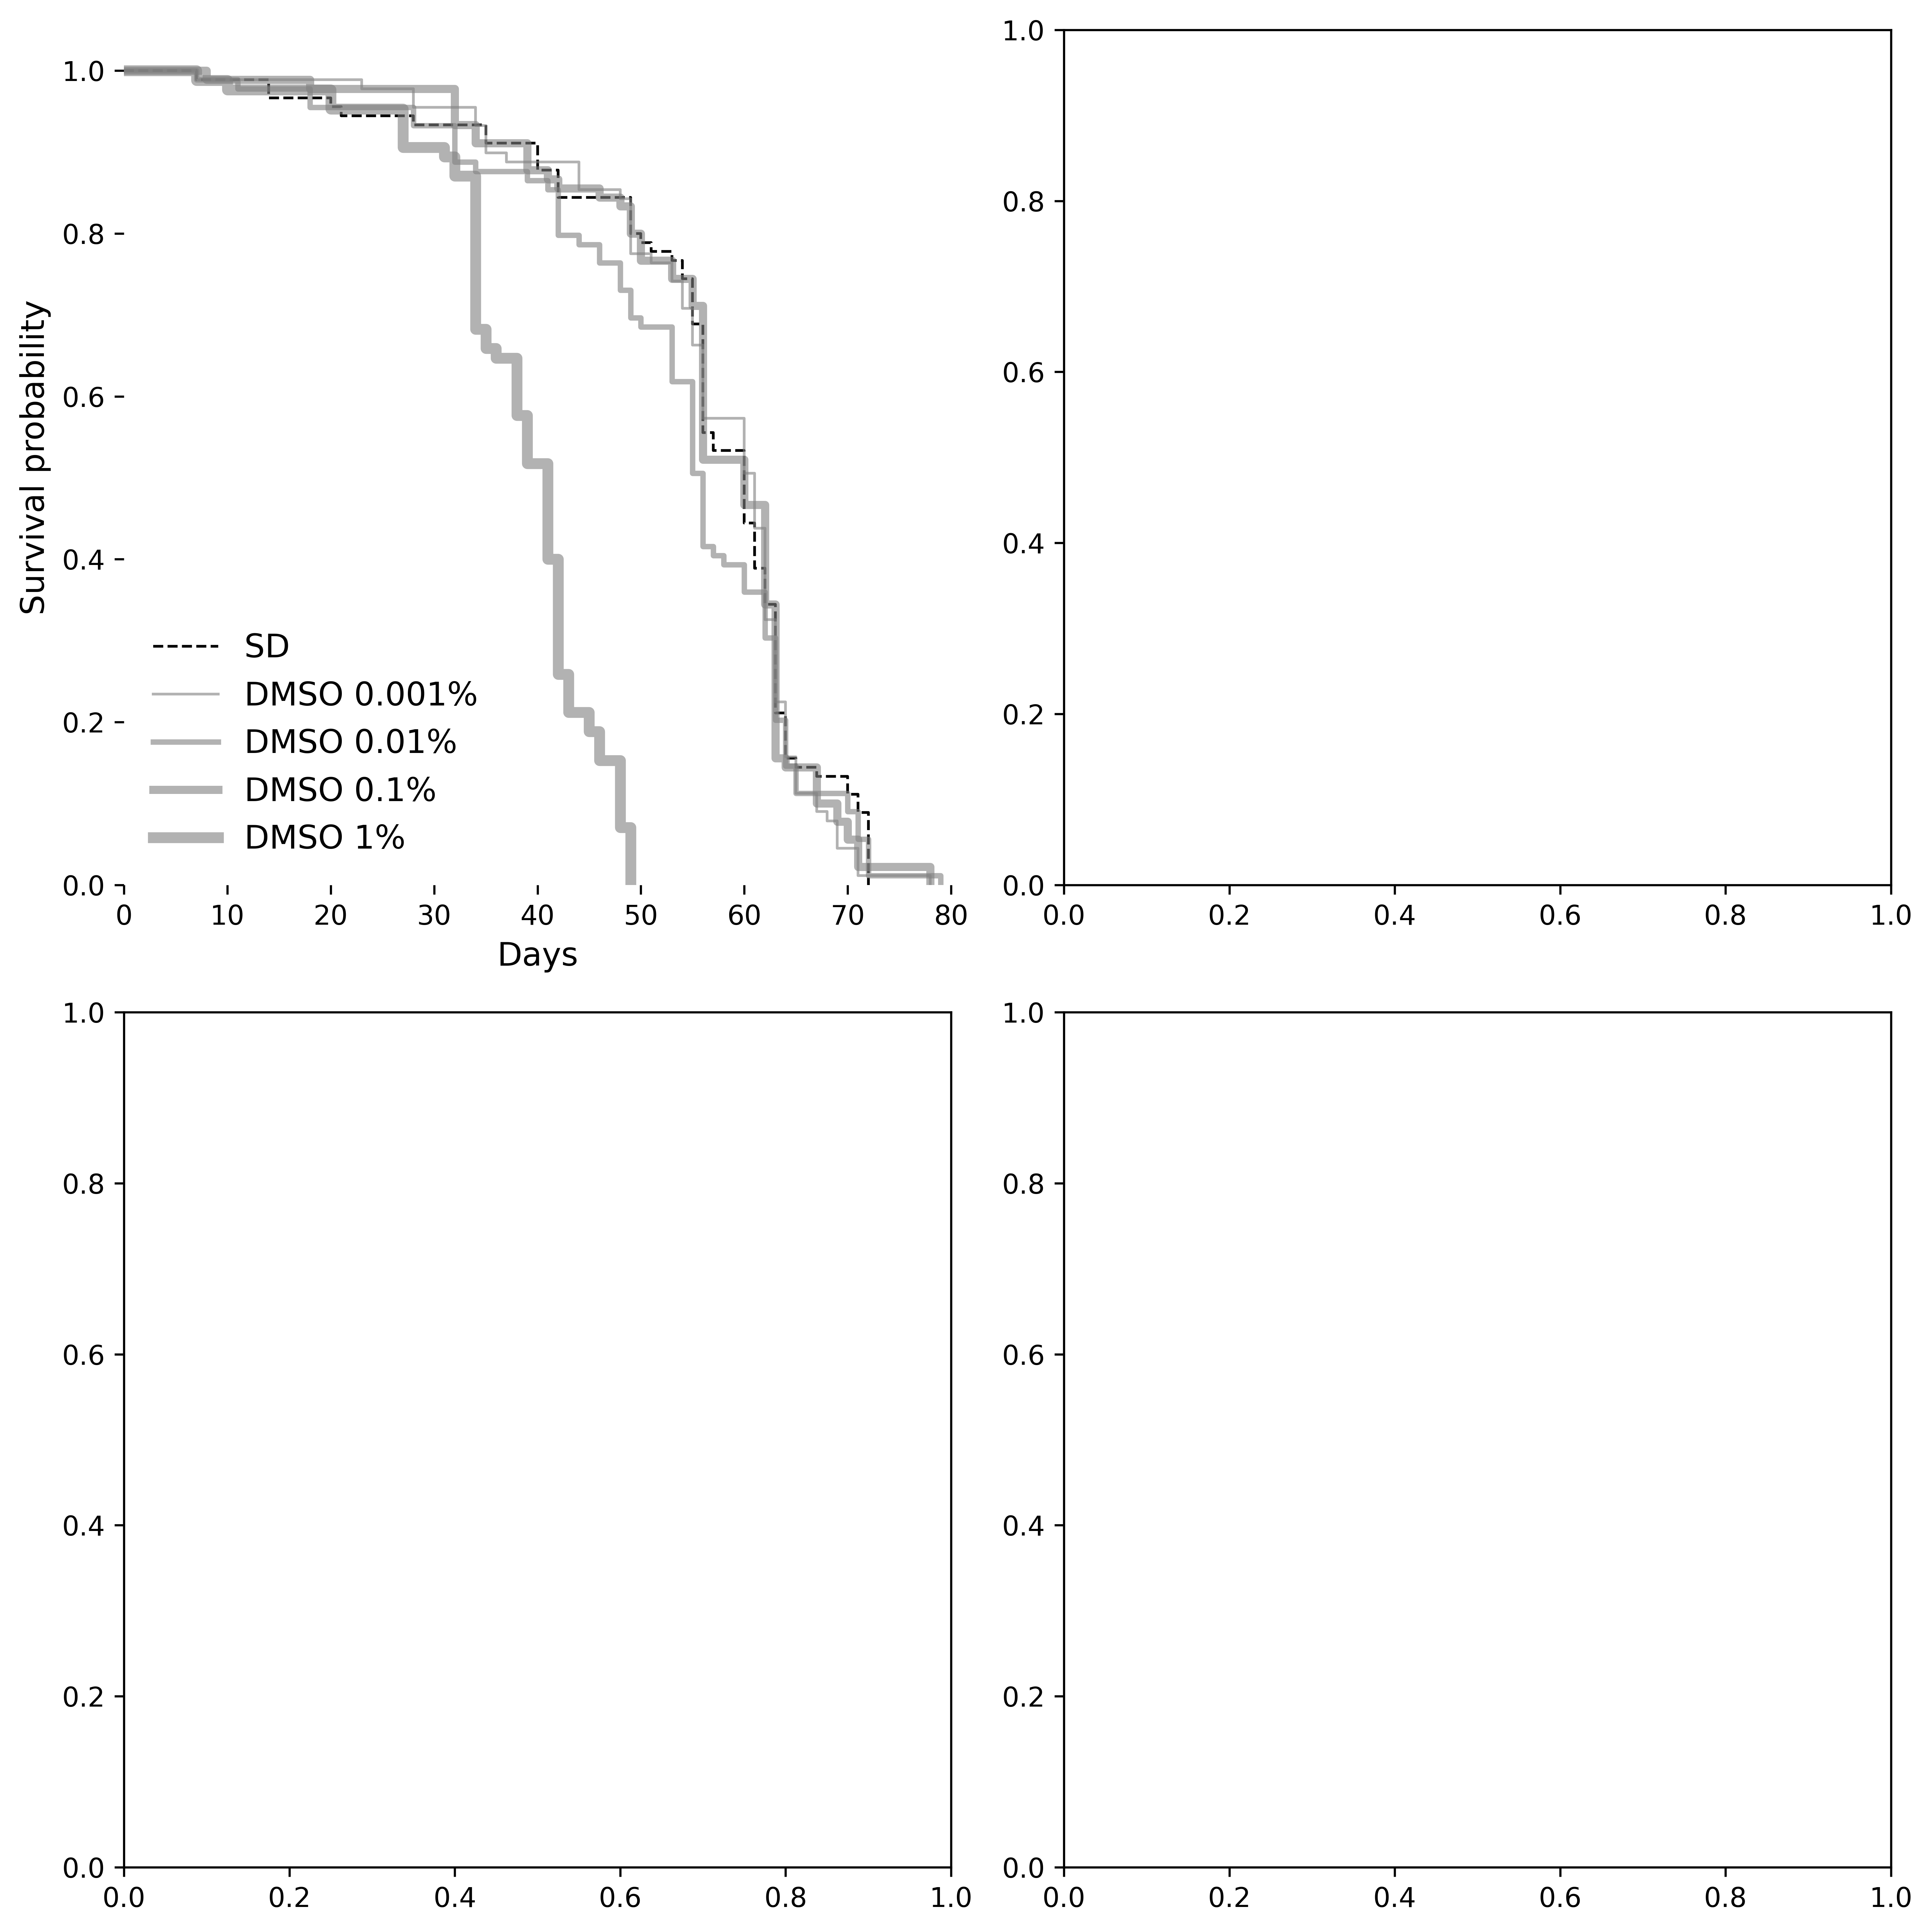

In [13]:
fig, axs = plt.subplots(2, 2, dpi=600, figsize=(10, 10))
plot_survival(axs[0, 0], lifespan_info, lifespan_data, ['SD', 'DMSO-01', 'DMSO-1', 'DMSO-10', 'DMSO-100'], False)
fig.tight_layout(); fig.savefig('KM_plots_AB_123_DMSO.png', transparent=False, facecolor='white')

In [14]:
fig, axs = plt.subplots(3, 5, dpi=1000, figsize=(10, 6))
plot_survival(axs[0, 0], lifespan_info, lifespan_data, ['A-01', 'DMSO-01'], True)
plot_survival(axs[0, 1], lifespan_info, lifespan_data, ['A-1', 'DMSO-1'], True)
plot_survival(axs[0, 2], lifespan_info, lifespan_data, ['A-10', 'DMSO-10'], True)
plot_survival(axs[0, 3], lifespan_info, lifespan_data, ['A-100', 'DMSO-100'], True)
plot_survival(axs[0, 4], lifespan_info, lifespan_data, ['SD', 'A-01', 'A-1', 'A-10', 'A-100', 'DMSO-01', 'DMSO-1', 'DMSO-10', 'DMSO-100'], False)

plot_survival(axs[1, 0], lifespan_info, lifespan_data, ['B-01', 'DMSO-01'], True)
plot_survival(axs[1, 1], lifespan_info, lifespan_data, ['B-1', 'DMSO-1'], True)
plot_survival(axs[1, 2], lifespan_info, lifespan_data, ['B-10', 'DMSO-10'], True)
plot_survival(axs[1, 3], lifespan_info, lifespan_data, ['B-100', 'DMSO-100'], True)
plot_survival(axs[1, 4], lifespan_info, lifespan_data, ['SD', 'B-01', 'B-1', 'B-10', 'B-100', 'DMSO-01', 'DMSO-1', 'DMSO-10', 'DMSO-100'], False)

plot_survival(axs[2, 0], lifespan_info, lifespan_data, ['A-01', 'B-01', 'DMSO-01'], False)
plot_survival(axs[2, 1], lifespan_info, lifespan_data, ['A-1', 'B-1', 'DMSO-1'], False)
plot_survival(axs[2, 2], lifespan_info, lifespan_data, ['A-10', 'B-10', 'DMSO-10'], False)
plot_survival(axs[2, 3], lifespan_info, lifespan_data, ['A-100', 'B-100', 'DMSO-100'], False)
plot_survival(axs[2, 4], lifespan_info, lifespan_data, ['SD', 'A-01', 'A-1', 'A-10', 'A-100', 'B-01', 'B-1', 'B-10', 'B-100', 'DMSO-01', 'DMSO-1', 'DMSO-10', 'DMSO-100'], False)

fig.tight_layout(); fig.savefig('KM_plots_AB_123.png', transparent=False, facecolor='white')


/tmp/ipykernel_601/2456731590.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(); fig.savefig('KM_plots_AB_123.png', transparent=False, facecolor='white')


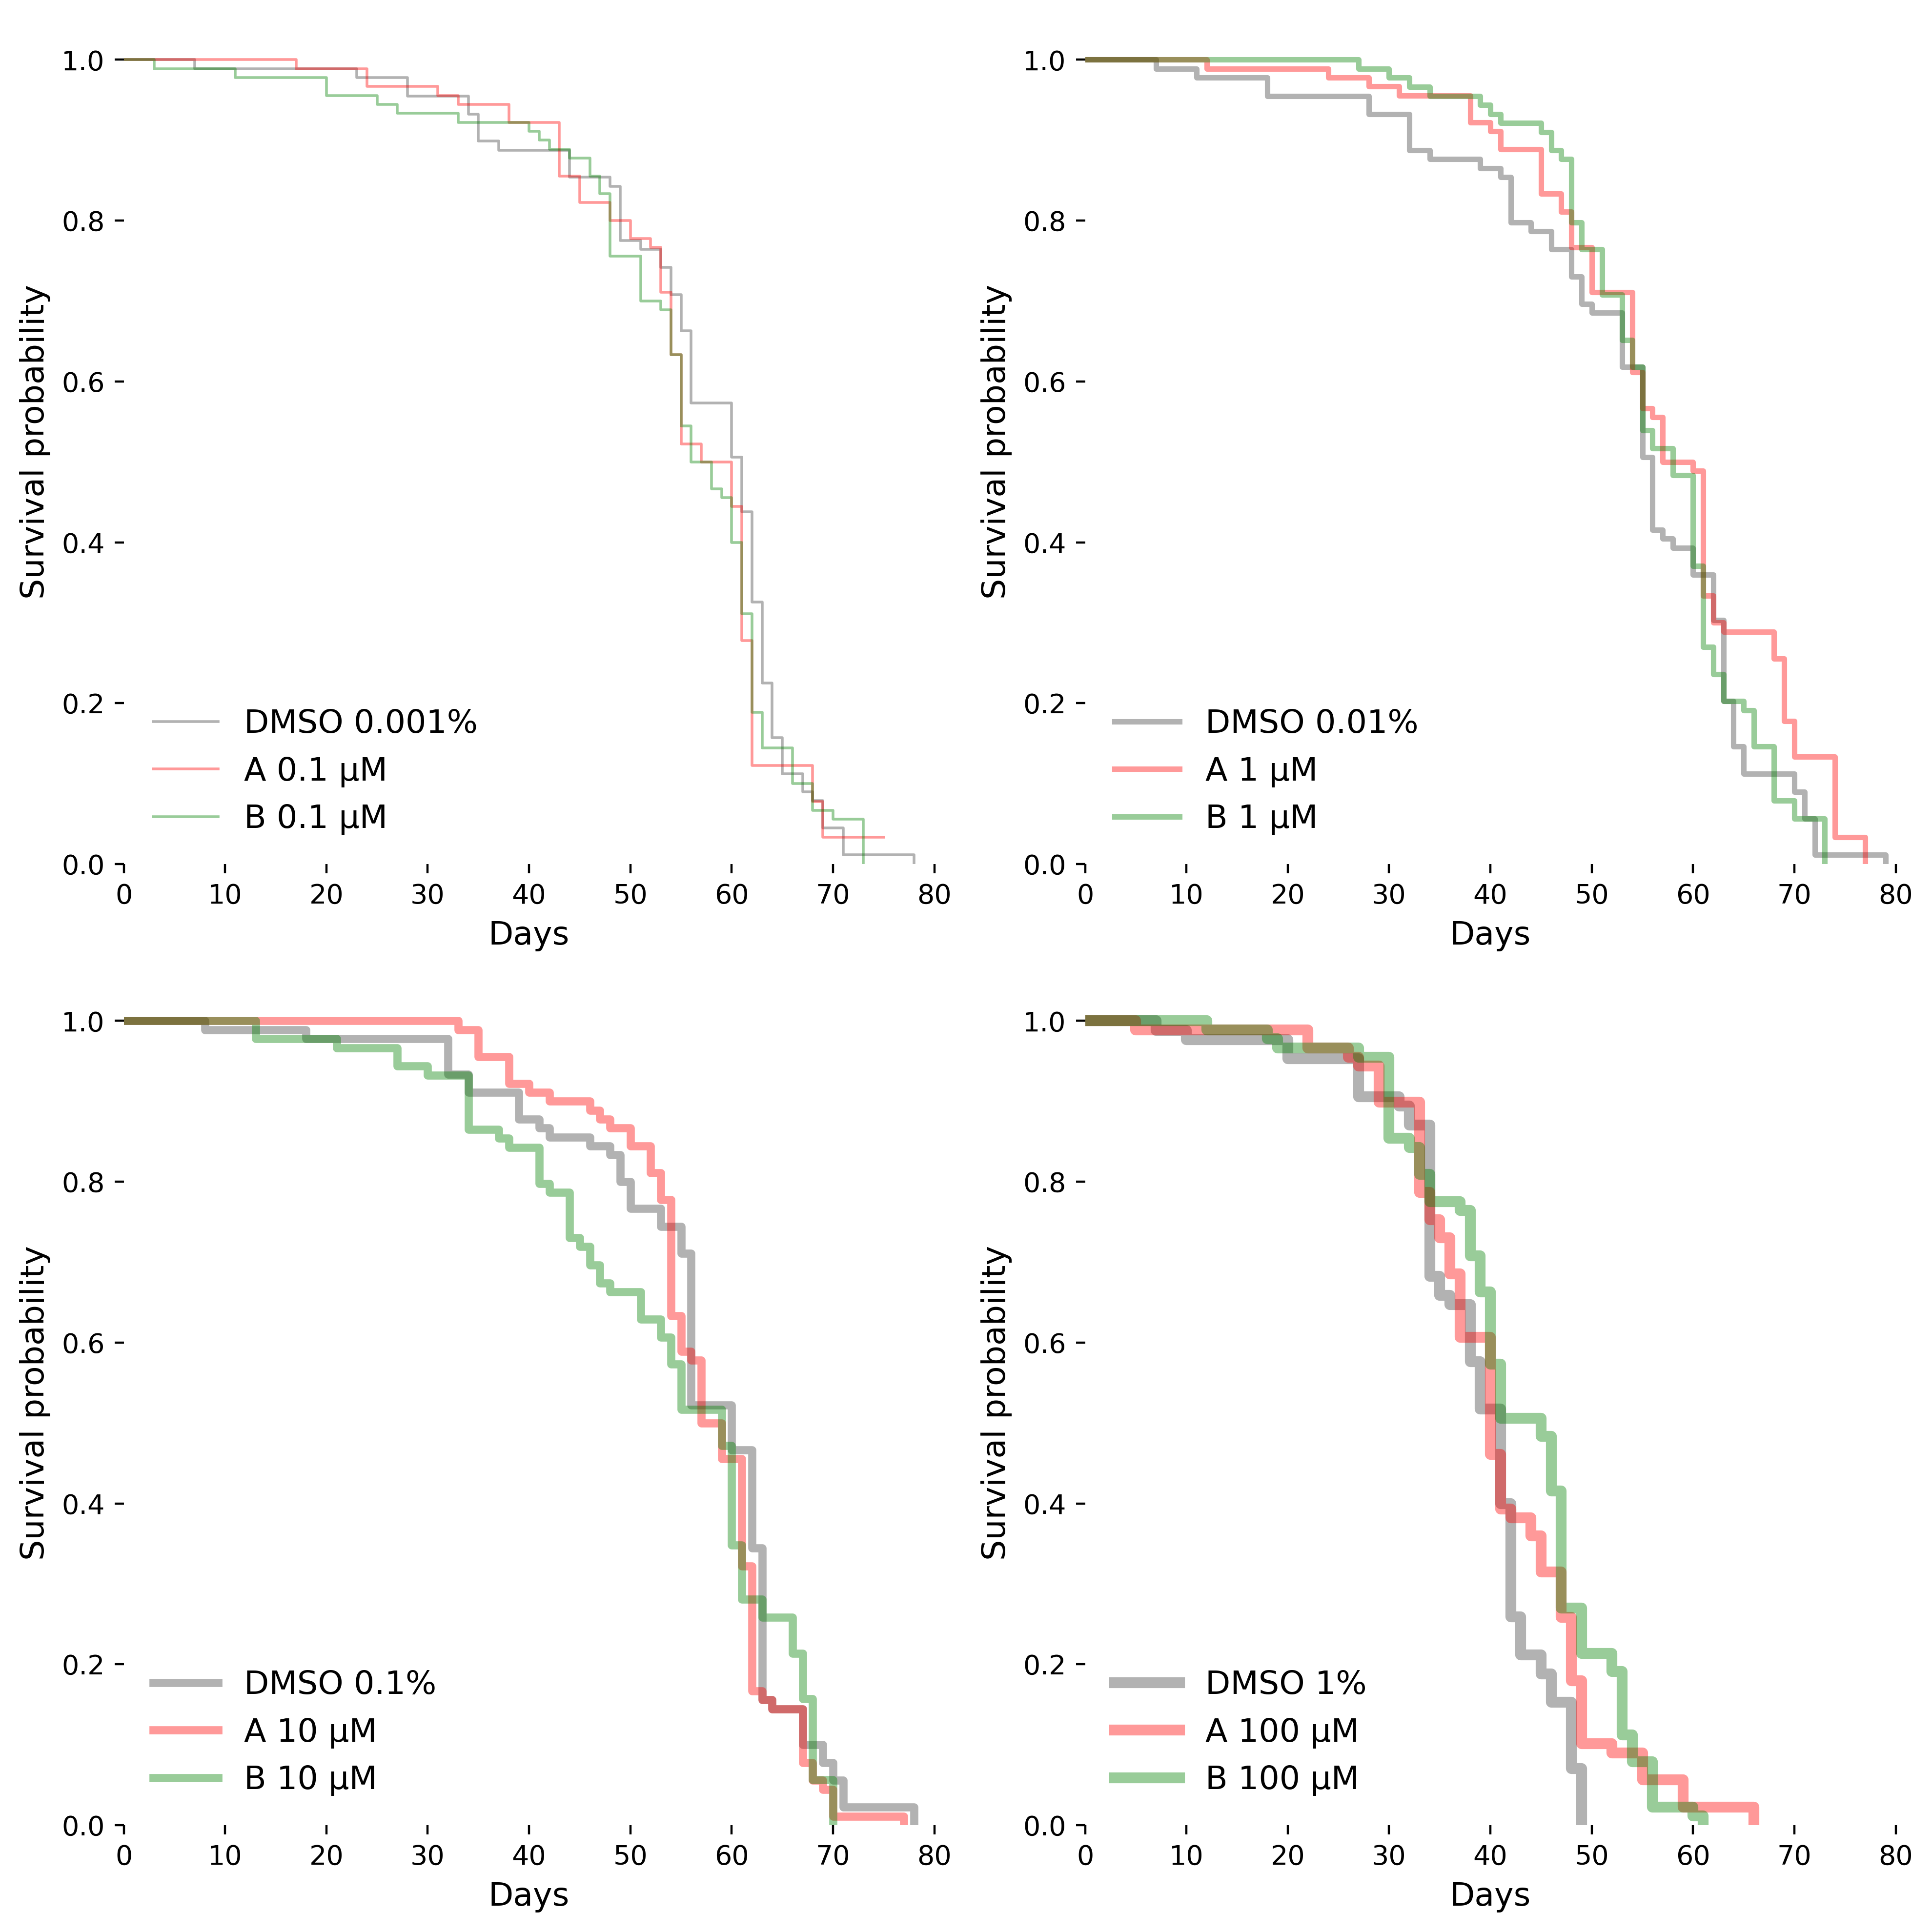

In [13]:
fig, axs = plt.subplots(2, 2, dpi=400, figsize=(10, 10))
plot_survival(axs[0, 0], lifespan_info, lifespan_data, ['DMSO-01', 'A-01', 'B-01'], False)
plot_survival(axs[0, 1], lifespan_info, lifespan_data, ['DMSO-1', 'A-1', 'B-1'], False)
plot_survival(axs[1, 0], lifespan_info, lifespan_data, ['DMSO-10', 'A-10', 'B-10'], False)
plot_survival(axs[1, 1], lifespan_info, lifespan_data, ['DMSO-100', 'A-100', 'B-100'], False)
fig.tight_layout(); fig.savefig('KM_plots_AB_123_AB-thin.png', transparent=False, facecolor='white')

In [19]:
lifespan_info

condition concentration compound  color  linewidth  alpha linestyle
condition                                                                    
A-01           A-01        0.1 µM        A    red        1.0    0.4         -
A-1             A-1          1 µM        A    red        2.0    0.4         -
A-10           A-10         10 µM        A    red        3.0    0.4         -
A-100         A-100        100 µM        A    red        4.0    0.4         -
B-01           B-01        0.1 µM        B  green        1.0    0.4         -
B-1             B-1          1 µM        B  green        2.0    0.4         -
B-10           B-10         10 µM        B  green        3.0    0.4         -
B-100         B-100        100 µM        B  green        4.0    0.4         -
DMSO-01     DMSO-01        0.001%     DMSO   grey        1.0    0.6         -
DMSO-1       DMSO-1         0.01%     DMSO   grey        2.0    0.6         -
DMSO-10     DMSO-10          0.1%     DMSO   grey        3.0    0.6         -
DMSO-100   DMSO-100            1%     DMSO   grey        4.0    0.6         -
SD               SD                     SD  black        1.0    1.0        --

In [20]:
#lifespan_data.to_csv('lifespan_data.tsv', sep='\t')
#lifespan_info.to_csv('lifespan_info.tsv', sep='\t')

In [ ]:
#plt.plot(x, y, drawstyle='steps-post', color=c, label=l, linewidth=lw, alpha=a, linestyle=ls)

In [47]:
lifespan_info

condition concentration compound  color  linewidth  alpha linestyle
condition                                                                    
A-01           A-01        0.1 µM        A    red        1.0    0.4         -
A-1             A-1          1 µM        A    red        2.0    0.4         -
A-10           A-10         10 µM        A    red        3.0    0.4         -
A-100         A-100        100 µM        A    red        4.0    0.4         -
B-01           B-01        0.1 µM        B  green        1.0    0.4         -
B-1             B-1          1 µM        B  green        2.0    0.4         -
B-10           B-10         10 µM        B  green        3.0    0.4         -
B-100         B-100        100 µM        B  green        4.0    0.4         -
DMSO-01     DMSO-01        0.001%     DMSO   grey        1.0    0.6         -
DMSO-1       DMSO-1         0.01%     DMSO   grey        2.0    0.6         -
DMSO-10     DMSO-10          0.1%     DMSO   grey        3.0    0.6         -
DMSO-100   DMSO-100            1%     DMSO   grey        4.0    0.6         -
SD               SD                     SD  black        1.0    1.0        --

In [ ]:
fig, ax = plt.subplots(figsize=(25,5))
sns.set_style('whitegrid')
sns.stripplot(y="slope", x="topic", data=df, jitter=False, palette="Blues_d", size=15)
sns.despine(offset=10, trim=True, left=True, bottom=True)
#plt.xticks(fontsize=0); plt.yticks(fontsize=0)
#plt.xlabel(''); plt.ylabel('')
plt.axvline(33, -1.5, 2)
plt.axvline(56, -1.5, 2)
plt.axvline(58, -1.5, 2)
#ax.xaxis.set_ticklabels([]); ax.yaxis.set_ticklabels([])
plt.tight_layout()
#plt.savefig('plots/'+tissue+'/'+tissue+'.'+model_type+'.plot_regression_slope.png', dpi=300, transparent=True); plt.close()

In [52]:
for dose in ['01', '1', '10', '100']:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.spines['right'].set_visible(False); ax.spines['left'].set_visible(False); ax.spines['top'].set_visible(False); ax.spines['bottom'].set_visible(False)
    ax.set_yticks([0, 0.5, 1.0]); ax.set_xlim([0, 80]); ax.set_ylim([0, 1.05]); ax.xaxis.set_ticklabels([]); ax.yaxis.set_ticklabels([])

    surv = lifespan_data.loc['DMSO-'+dose]['survs']
    kmf = KaplanMeierFitter(); kmf.fit(surv['T'], event_observed=surv['E'])
    plt.plot(kmf.survival_function_.index, 
             kmf.survival_function_['KM_estimate'], 
             drawstyle='steps-post', color='grey')

    surv = lifespan_data.loc['A-'+dose]['survs']
    kmf = KaplanMeierFitter(); kmf.fit(surv['T'], event_observed=surv['E'])
    plt.plot(kmf.survival_function_.index, 
             kmf.survival_function_['KM_estimate'], 
             drawstyle='steps-post', color='red')

    surv = lifespan_data.loc['B-'+dose]['survs']
    kmf = KaplanMeierFitter(); kmf.fit(surv['T'], event_observed=surv['E'])
    plt.plot(kmf.survival_function_.index, 
             kmf.survival_function_['KM_estimate'], 
             drawstyle='steps-post', color='blue')

    plt.savefig('surv-'+dose+'.png', dpi=300, transparent=True); plt.close(fig)

In [61]:
1.0025**251

1.8714563599042982

DMSO-01
A-01
B-01
['DMSO-01', 'A-01', 'B-01'].png


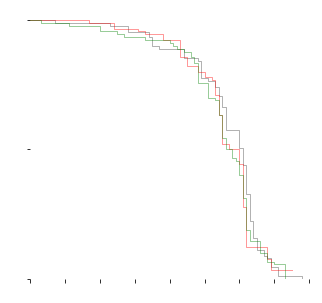

In [25]:
plot_survival(lifespan_info, lifespan_data, ['DMSO-01', 'A-01', 'B-01'], False)

DMSO-01
A-01
['DMSO-01', 'A-01'].png
DMSO-1
A-1
['DMSO-1', 'A-1'].png
DMSO-10
A-10
['DMSO-10', 'A-10'].png
DMSO-100
A-100
['DMSO-100', 'A-100'].png
DMSO-01
B-01
['DMSO-01', 'B-01'].png
DMSO-1
B-1
['DMSO-1', 'B-1'].png
DMSO-10
B-10
['DMSO-10', 'B-10'].png
DMSO-100
B-100
['DMSO-100', 'B-100'].png


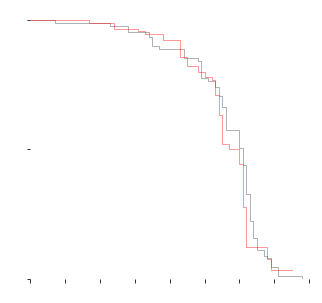

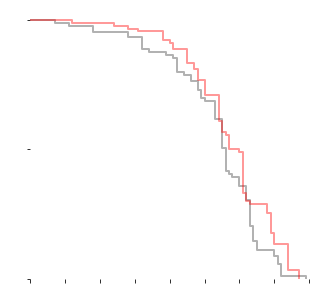

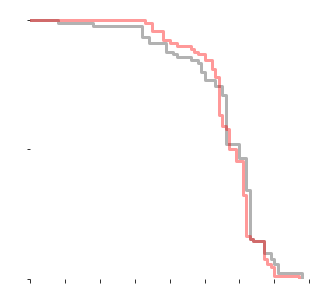

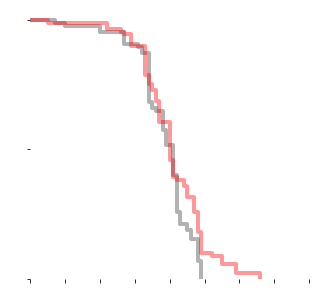

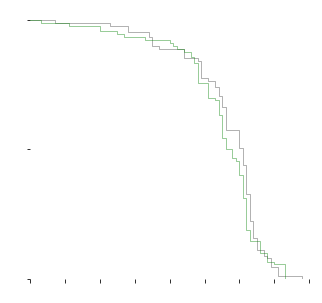

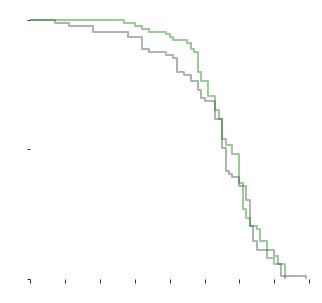

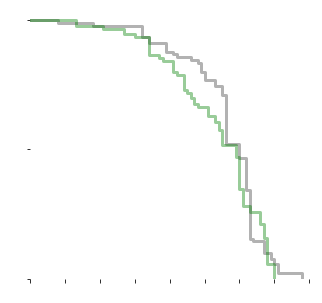

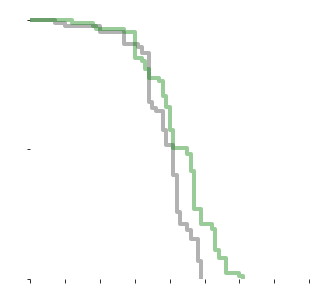

In [23]:
def km_fit(surv):
    kmf = KaplanMeierFitter(); kmf.fit(surv['T'], event_observed=surv['E'])
    return(kmf)

def plot_survival_curve(ax, x, y, y1, y2, c, l, lw, a, ls, ci, condition):

    #ax.set_xlabel('Days', fontsize='large'); ax.set_ylabel('Survival probability', fontsize='large')
    plt.plot(x, y, drawstyle='steps-post', color=c, label=l, linewidth=lw, alpha=a, linestyle=ls)
    #if ci==True:
    #    ax.fill_between(x, y1, y2, step='post', color=c, alpha=a/5)
    #ax.legend(fontsize=12, frameon=False, loc=3)
    
def plot_survival(lifespan_info, lifespan_data, conditions, ci):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    #ax.set_xticks([]); ax.set_yticks([])
    ax.set_yticks([0, 0.5, 1.0])
    ax.set_xlim([0, 80])
    ax.set_ylim([0, 1.05])
    #plt.xticks(fontsize=0); plt.yticks(fontsize=0)
    plt.xticks(color='w')
    plt.yticks(color='w')

    for condition in conditions:
        print(condition)
        info = lifespan_info.loc[condition]
        #kmf = km_fit(lifespan_data.loc[condition].to_numpy())
        kmf = km_fit((lifespan_data.loc[condition]['survs']))
        plot_survival_curve(ax, 
                            kmf.survival_function_.index, 
                            kmf.survival_function_['KM_estimate'], 
                            kmf.confidence_interval_survival_function_['KM_estimate_lower_0.95'],
                            kmf.confidence_interval_survival_function_['KM_estimate_upper_0.95'],
                            info['color'],
                            (info['compound']+' '+info['concentration']), 
                            info['linewidth'], 
                            info['alpha'],
                            info['linestyle'],
                           ci, condition)
    file_name = str(conditions) +'.png'
    print(file_name)
    #plt.savefig(file_name +'.png', dpi=300, transparent=True); plt.close(fig)
plot_survival(lifespan_info, lifespan_data, ['DMSO-01', 'A-01'], False)
plot_survival(lifespan_info, lifespan_data, ['DMSO-1', 'A-1'], False)
plot_survival(lifespan_info, lifespan_data, ['DMSO-10', 'A-10'], False)
plot_survival(lifespan_info, lifespan_data, ['DMSO-100', 'A-100'], False)
plot_survival(lifespan_info, lifespan_data, ['DMSO-01', 'B-01'], False)
plot_survival(lifespan_info, lifespan_data, ['DMSO-1', 'B-1'], False)
plot_survival(lifespan_info, lifespan_data, ['DMSO-10', 'B-10'], False)
plot_survival(lifespan_info, lifespan_data, ['DMSO-100', 'B-100'], False)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([]); ax.set_yticks([])
ax.spines['right'].set_visible(False); ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False); ax.spines['top'].set_visible(False)
sc = plt.scatter(
    embedding[:,0][start_age:end_age], 
    embedding[:,1][start_age:end_age], 
    cmap='coolwarm', 
    c=np.arange(embedding.shape[0])[start_age:end_age], 
    s=500)
plt.savefig('plots/'+tissue+'/'+tissue+'.'+matrix+'.pca.png', dpi=300, transparent=True)
cbar = fig.colorbar(sc, ax=ax)
cbar.ax.tick_params(labelsize=0)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=1)
plt.savefig('plots/'+tissue+'/'+tissue+'.'+matrix+'.pca.cb.png', dpi=300, transparent=True); plt.close(fig)

In [48]:

#plot_survival(ax, lifespan_info, lifespan_data, ['DMSO-1', 'A-1'], False)
#plot_survival(ax, lifespan_info, lifespan_data, ['DMSO-10', 'A-10'], False)
#plot_survival(ax, lifespan_info, lifespan_data, ['DMSO-100', 'A-100'], False)
#fig.tight_layout(); fig.savefig('KM_plots_AB_123_A-wide.png', transparent=False, facecolor='white')

DMSO-01
A-01
DMSO-1
A-1
DMSO-10
A-10
DMSO-100
A-100


In [18]:
fig, axs = plt.subplots(2, 2, dpi=1000, figsize=(10, 10))
plot_survival(axs[0, 0], lifespan_info, lifespan_data, ['DMSO-01', 'B-01'], False)
plot_survival(axs[0, 1], lifespan_info, lifespan_data, ['DMSO-1', 'B-1'], False)
plot_survival(axs[1, 0], lifespan_info, lifespan_data, ['DMSO-10', 'B-10'], False)
plot_survival(axs[1, 1], lifespan_info, lifespan_data, ['DMSO-100', 'B-100'], False)
fig.tight_layout(); fig.savefig('KM_plots_AB_123_B-wide.png', transparent=False, facecolor='white')

In [12]:
DMSO10=lifespan_data.loc['DMSO-10']
DMSO10=DMSO10['survs']
T_DMSO10=DMSO10['T']
E_DMSO10=DMSO10['E']


B10=lifespan_data.loc['B-10']
B10=B10['survs']
T_B10=B10['T']
E_B10=B10['E']


results=logrank_test(T_DMSO10, T_B10, event_observed_A=E_DMSO10, event_observed_B=E_B10)
results.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.46 0.23      2.14

In [14]:
logrank_test(T_DMSO100, T_B100, event_observed_DMSOA=E_DMSO100, event_observed_B=E_B100)

<lifelines.StatisticalResult: logrank_test>
                 t_0 = -1
   null_distribution = chi squared
  degrees_of_freedom = 1
event_observed_DMSOA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
           test_name = logrank_test

---
 test_statistic      p  -log2(p)
          15.49 <0.005     13.55

In [13]:
DMSO100=lifespan_data.loc['DMSO-100']
DMSO100=DMSO100['survs']
T_DMSO100=DMSO100['T']
E_DMSO100=DMSO100['E']


B100=lifespan_data.loc['B-100']
B100=B100['survs']
T_B100=B100['T']
E_B100=B100['E']


results=logrank_test(T_DMSO100, T_B100, event_observed_DMSOA=E_DMSO100, event_observed_B=E_B100)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
                 t_0 = -1
   null_distribution = chi squared
  degrees_of_freedom = 1
event_observed_DMSOA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
           test_name = logrank_test

---
 test_statistic      p  -log2(p)
          15.49 <0.005     13.55

In [86]:
DMSO100=lifespan_data.loc['DMSO-100']
DMSO100=DMSO100['survs']



T_DMSO100=DMSO100['T']
E_DMSO100=DMSO100['E']



A100=lifespan_data.loc['A-100']
A100=A100['survs']



T_A100=A100['T']
E_A100=A100['E']


results=logrank_test(T_DMSO100, T_A100, event_observed_A=E_DMSO100, event_observed_B=E_A100)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.96 0.05      4.42

In [ ]:
pd.DataFrame(DMSO100).to_csv('DMSO100.csv', index=None)
pd.DataFrame(B100).to_csv('B100.csv', index=None)

In [121]:
import pandas as pd
B100 = pd.read_csv('B100.csv')
DMSO100 = pd.read_csv('DMSO100.csv')
df = pd.concat([B100, DMSO100])
df = df.reset_index(drop=True)
df['B100'] = df.apply(lambda _: '', axis=1)
df['DMSO100'] = df.apply(lambda _: '', axis=1)
df.loc[:B100.shape[0]-1,'B100'] = B100['E'].astype(str).tolist()
df.loc[B100.shape[0]:,'DMSO100'] = DMSO100['E'].astype(str).tolist()
df[['T', 'B100', 'DMSO100']].to_csv('prism.csv', index=False)

In [ ]:
surv = Survs(np.array(lifespan_data.iloc[1][0]))
kmf = KaplanMeierFitter()
kmf.fit(surv['T'], event_observed=surv['E'])
kmf.plot_survival_function(show_censors=True, at_risk_counts=True)

# Daily live counts adjusted

In [ ]:
daily_live_counts_adjusted = []
for idx in range(daily_live_counts.shape[0]):
    dlc = daily_live_counts[idx,np.argwhere(daily_live_counts[idx,:]!=0).min():]
    dlc = np.concatenate((dlc,(day_span-dlc.shape[0])*[0])).astype(int)
    daily_live_counts_adjusted.append(dlc)
daily_live_counts_adjusted = np.array(daily_live_counts_adjusted)
daily_live_counts_adjusted

In [ ]:
#(daily_live_counts_adjusted.sum(axis=0)>0).sum()

In [ ]:
lifespan['daily_live_counts_adjusted'] = daily_live_counts_adjusted.tolist()
lifespan_data = lifespan[['condition', 'daily_live_counts_adjusted']]
lifespan_data = lifespan_data.apply(list).groupby(by='condition')['daily_live_counts_adjusted'].apply(list).groupby(level=0).apply(list)

In [ ]:
surv = Survs(np.array(lifespan_data.iloc[0][0]))
kmf = KaplanMeierFitter()
kmf.fit(surv['T'], event_observed=surv['E'])
kmf.plot_survival_function(show_censors=True, at_risk_counts=True)

# Lifespan data